In [2]:
import pandas
import math
import sklearn
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data_train = pandas.read_csv('train.csv', index_col = 'PassengerId')
#print(data_train[:5])
data_test = pandas.read_csv('test.csv', index_col = 'PassengerId')
#print(data_test[:5])
data_train[:10]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [9]:
def print_nan(X):
    counts = X.count()
    length = X.shape[0]
    print('Full length:', length)
    for i in counts[counts < length].index:
        print(i, ': Non NaN num:', counts[i], ', Not NaN:', '%.3f' % (100*counts[i] / length), '%')
    return

def fill_nan(X):
    return X.fillna(value = -1)

def get_marital_status(name):
    if (name.find('Mrs') != -1):
        return 2
    else:
        if (name.find('Miss') != -1):
            return 1
        else:
            if (name.find('Mr') != -1):
                return 0
            else:
                return -1

def prepare_data(X):
    print_nan(X)
    X = fill_nan(X)
    X['MaritalStatus'] = X['Name'].map(get_marital_status)
    X['Sex'] = X['Sex'].map(lambda x: 1 if x == 'male' else 0)
    X['Embarked'] = X['Embarked'].map(lambda x: 0 if x == 'C' else (1 if x == 'Q' else (2 if x == 'S' else -1)))
    return X

data_train = prepare_data(data_train)
X_train = data_train.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)
y_train = data_train['Survived']
data_test = prepare_data(data_test)
X_test = data_test.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

Full length: 891
Age : Non NaN num: 714 , Not NaN: 80.135 %
Cabin : Non NaN num: 204 , Not NaN: 22.896 %
Embarked : Non NaN num: 889 , Not NaN: 99.776 %
Full length: 418
Age : Non NaN num: 332 , Not NaN: 79.426 %
Fare : Non NaN num: 417 , Not NaN: 99.761 %
Cabin : Non NaN num: 91 , Not NaN: 21.770 %


In [3]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 241)
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)
n_est = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500]
scores_gbc = []
scores_rfc = []
scores_ada = []
print('N_est| GBC | RFC | Ada')
for n in n_est:
    # print ('Number of estimators: ', str(n))
    gbc = GradientBoostingClassifier(n_estimators=n, random_state = 241)
    rfc = RandomForestClassifier(n_estimators=n, random_state = 241)   
    ada = AdaBoostClassifier(n_estimators = n, random_state = 241)
    gbc_scores = np.mean(cross_val_score(estimator = gbc, X = X_train, y = y_train, cv=cv, scoring='roc_auc'))
    rfc_scores = np.mean(cross_val_score(estimator = rfc, X = X_train, y = y_train, cv=cv, scoring='roc_auc'))
    ada_scores = np.mean(cross_val_score(estimator = ada, X = X_train, y = y_train, cv=cv, scoring='roc_auc'))
    print ("%5.f" % n, "%.3f" % gbc_scores, "%.3f" % rfc_scores, "%.3f" % ada_scores)
    scores_gbc.append(gbc_scores)
    scores_rfc.append(rfc_scores)
    scores_ada.append(ada_scores)

N_est| GBC | RFC | Ada
   10 0.859 0.860 0.850
   20 0.861 0.861 0.857
   30 0.862 0.860 0.855
   40 0.865 0.860 0.857
   50 0.867 0.860 0.859
  100 0.870 0.860 0.857
  200 0.873 0.860 0.858
  300 0.869 0.860 0.857
  400 0.866 0.860 0.854
  500 0.865 0.860 0.854


In [4]:
print('Logistic, SVC')
scores_lr = []
scores_svc = []
C_pows = range(-5, 6)
C_range = [10.0 ** i for i in C_pows]
for C in C_range:
    lr = LogisticRegression(C=C)    
    svc = SVC(C=C)
    lr_scores = np.mean(cross_val_score(estimator = lr, X = X_train_transformed, y = y_train, cv=cv, scoring='roc_auc'))
    svc_scores = np.mean(cross_val_score(estimator = svc, X = X_train_transformed, y = y_train, cv=cv, scoring='roc_auc'))
    print ('C =', "%11.5f" % C, "%.3f" % lr_scores, "%.3f" % svc_scores,)
    scores_lr.append(lr_scores)
    scores_svc.append(svc_scores)

Logistic, SVC
C =     0.00001 0.811 0.834
C =     0.00010 0.811 0.835
C =     0.00100 0.816 0.836
C =     0.01000 0.826 0.835
C =     0.10000 0.844 0.837
C =     1.00000 0.846 0.843
C =    10.00000 0.846 0.821
C =   100.00000 0.846 0.806
C =  1000.00000 0.846 0.797
C = 10000.00000 0.846 0.757
C = 100000.00000 0.846 0.747


In [5]:
scores_knn = []
print('N_neigh | Knn')
for n in range(1, 51):
    # print ('Number of estimators: ', str(n))
    knn = KNeighborsClassifier(n_neighbors=n)    
    knn_scores = np.mean(cross_val_score(estimator = knn, X = X_train_transformed, y = y_train, cv=cv, scoring='roc_auc'))
    print ("%5.f" % n, "%.3f" % knn_scores)
    scores_knn.append(knn_scores)
    

N_neigh | Knn
    1 0.740
    2 0.799
    3 0.822
    4 0.841
    5 0.853
    6 0.854
    7 0.858
    8 0.859
    9 0.858
   10 0.854
   11 0.856
   12 0.854
   13 0.856
   14 0.855
   15 0.853
   16 0.852
   17 0.853
   18 0.851
   19 0.852
   20 0.852
   21 0.852
   22 0.849
   23 0.849
   24 0.849
   25 0.848
   26 0.849
   27 0.849
   28 0.850
   29 0.849
   30 0.850
   31 0.849
   32 0.848
   33 0.848
   34 0.848
   35 0.850
   36 0.851
   37 0.849
   38 0.850
   39 0.849
   40 0.850
   41 0.851
   42 0.850
   43 0.849
   44 0.849
   45 0.849
   46 0.848
   47 0.850
   48 0.849
   49 0.850
   50 0.850


In [6]:
scores_gbc = []
print('N_est| GBC')
for n in np.linspace(start = 100, stop = 300, num = 20):
    # print ('Number of estimators: ', str(n))
    gbc = GradientBoostingClassifier(n_estimators = int(n), random_state = 241)
    gbc_scores = np.mean(cross_val_score(estimator = gbc, X = X_train, y = y_train, cv=cv, scoring='roc_auc'))
    print ("%5.f" % n, "%.3f" % gbc_scores)
    scores_gbc.append(gbc_scores)

N_est| GBC
  100 0.870
  111 0.870
  121 0.869
  132 0.871
  142 0.872
  153 0.874
  163 0.875
  174 0.874
  184 0.874
  195 0.873
  205 0.873
  216 0.874
  226 0.872
  237 0.871
  247 0.870
  258 0.870
  268 0.869
  279 0.870
  289 0.869
  300 0.869


In [7]:
n_est = 160
scores_gbc = []
print('Rate | GBC')
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1, 0.05, 0.025]:
    # print ('Number of estimators: ', str(n))
    gbc = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_est, random_state = 241)
    gbc_scores = np.mean(cross_val_score(estimator = gbc, X = X_train, y = y_train, cv=cv, scoring='roc_auc'))
    print ("%.2f" % learning_rate, "%.3f" % gbc_scores)
    scores_gbc.append(gbc_scores)

Rate | GBC
1.00 0.838
0.50 0.859
0.30 0.866
0.20 0.870
0.10 0.875
0.05 0.867
0.03 0.865


In [9]:
titanic = GradientBoostingClassifier(n_estimators = 160, learning_rate = 0.05, random_state = 241)
titanic.fit(X_train, y_train)
y_test = pandas.DataFrame(data = {'Survived' : titanic.predict(X_test)})
# y_test['Survived'] = pandas.DataFrame(titanic.predict(X_test))
#y_test.index.name = 'PassengerId'
y_test.index = X_test.index
y_test[:3]

,Survived
PassengerId,
892,0
893,0
894,0


In [10]:
y_test.to_csv('titanic_predict.csv')

In [11]:
print(X_train.shape, X_test.shape)
data_train.reset_index().groupby(['Embarked', 'Survived'])['PassengerId'].count()

(891, 8) (418, 8)


Embarked  Survived
-1        1             2
 0        0            75
          1            93
 1        0            47
          1            30
 2        0           427
          1           217
Name: PassengerId, dtype: int64

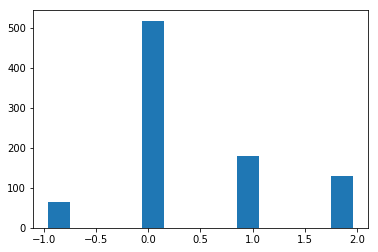

In [38]:
hist, bins = np.histogram(X_train['MaritalStatus'], bins = 10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

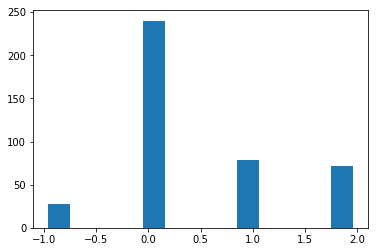

In [39]:
hist, bins = np.histogram(X_test['MaritalStatus'], bins = 10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [24]:
X_train[:3]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaritalStatus
PassengerId,,,,,,,,
1,3,1,22.0,1,0,7.2500,2,0
2,1,0,38.0,1,0,71.2833,0,2
3,3,0,26.0,0,0,7.9250,2,1


In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 8)
pca.fit(X_train)
dispmax = 0.9
disp = 0
i = 0
while (disp < dispmax):
    disp += pca.explained_variance_ratio_[i]
    i += 1    
print('Для описания', dispmax, 'дисперсии требуется', i, 'компонент')

Для описания 0.9 дисперсии требуется 2 компонент


In [44]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [58]:
from sklearn.model_selection import GridSearchCV
grid = {'n_estimators' : [1, 2, 3, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'learning_rate' : [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]}
cv = KFold(n_splits = 5, shuffle = True, random_state = 241)
gbc = GradientBoostingClassifier(random_state = 241)
gs = GridSearchCV(gbc, grid, scoring = 'roc_auc', cv = cv)
gs.fit(X_train_pca, y_train)
print(gs.best_params_)

{'learning_rate': 0.05, 'n_estimators': 20}


In [70]:
learning_rate = gs.best_params_.get('learning_rate')
n_estimators = gs.best_params_.get('n_estimators')
cv = KFold(n_splits = 5, shuffle = True, random_state = 241)
gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, random_state = 241)
scores = np.mean(cross_val_score(estimator = gbc, X = X_train_pca, y = y_train, cv = cv, scoring='roc_auc'))
print ("%.3f" % gbc_scores)

0.865


In [72]:
titanic = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.05, random_state = 241)
titanic.fit(X_train_pca, y_train)
y_test = pandas.DataFrame(data = {'Survived' : titanic.predict(X_test_pca)})
# y_test['Survived'] = pandas.DataFrame(titanic.predict(X_test))
#y_test.index.name = 'PassengerId'
y_test.index = X_test.index
y_test[:3]
y_test.to_csv('titanic_predict.csv')